# КТ 1 

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

import shap
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler

In [6]:
df = pd.read_csv('housing.csv')

План действий: 

1. Предобработка данных
2. Кодирование категориальных признаков
3. Построить обычную линейную регрессию на всем наборе данных, используя в качестве метода подгонки МНК
4. Отбираем признаки и делаем по ним
5. Регуляризация и фиктивные переменные

#### Предобработка данных

In [8]:
df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,sub_area,area_m,...,metro_min_walk,metro_km_walk,mkad_km,kremlin_km,green_part_1000,prom_part_1000,office_count_1000,trc_count_1000,leisure_count_1000,price_doc
0,38,18.0,1.0,14.0,panel,1971.0,1.0,9.0,Dmitrovskoe,7.126815e+06,...,27.084184,2.257015,2.442781,14.856442,17.16,10.33,2,4,0,5150000
1,41,17.0,14.0,16.0,panel,1978.0,1.0,10.0,Savelovskoe,2.641243e+06,...,13.719174,1.143264,11.528984,5.323699,0.90,39.48,17,3,0,5980000
2,41,20.0,11.0,14.0,panel,1989.0,1.0,8.0,Krjukovo,1.084231e+07,...,276.453594,23.037800,20.828299,38.988909,7.54,6.64,0,2,0,4600000
3,38,19.0,6.0,17.0,panel,1986.0,1.0,8.0,Brateevo,7.587523e+06,...,14.085660,1.173805,2.885041,14.921056,24.97,0.00,0,5,0,5650000
4,58,37.0,3.0,9.0,panel,1968.0,3.0,6.0,Novogireevo,4.395333e+06,...,5.455795,0.454650,1.920884,11.812614,3.46,5.41,0,4,4,9300000


In [10]:
df.dtypes

full_sq                 int64
life_sq               float64
floor                 float64
max_floor             float64
material               object
build_year            float64
num_room              float64
kitch_sq              float64
sub_area               object
area_m                float64
green_zone_part       float64
indust_part           float64
preschool               int64
school                  int64
healthcare              int64
shopping                int64
office                  int64
radiation              object
detention              object
young                   int64
work                    int64
elder                   int64
0_6_age                 int64
7_14_age                int64
metro_min_avto        float64
metro_km_avto         float64
metro_min_walk        float64
metro_km_walk         float64
mkad_km               float64
kremlin_km            float64
green_part_1000       float64
prom_part_1000        float64
office_count_1000       int64
trc_count_

In [11]:
df.shape

(8894, 36)

In [12]:
df.isna().sum()

full_sq                0
life_sq                0
floor                  0
max_floor              0
material               0
build_year            35
num_room               0
kitch_sq               0
sub_area               0
area_m                 0
green_zone_part        0
indust_part            0
preschool              0
school                 0
healthcare             0
shopping               0
office                 0
radiation              0
detention              0
young                  0
work                   0
elder                  0
0_6_age                0
7_14_age               0
metro_min_avto         0
metro_km_avto          0
metro_min_walk        11
metro_km_walk         11
mkad_km                0
kremlin_km             0
green_part_1000        0
prom_part_1000         0
office_count_1000      0
trc_count_1000         0
leisure_count_1000     0
price_doc              0
dtype: int64

In [13]:
df = df.dropna()

In [14]:
df.shape

(8848, 36)

In [ ]:
df.duplicated().sum() 

42

In [18]:
df = df.drop_duplicates() #удаляем дубликаты

In [20]:
df.T.duplicated()

full_sq               False
life_sq               False
floor                 False
max_floor             False
material              False
build_year            False
num_room              False
kitch_sq              False
sub_area              False
area_m                False
green_zone_part       False
indust_part           False
preschool             False
school                False
healthcare            False
shopping              False
office                False
radiation             False
detention             False
young                 False
work                  False
elder                 False
0_6_age               False
7_14_age              False
metro_min_avto        False
metro_km_avto         False
metro_min_walk        False
metro_km_walk         False
mkad_km               False
kremlin_km            False
green_part_1000       False
prom_part_1000        False
office_count_1000     False
trc_count_1000        False
leisure_count_1000    False
price_doc           

<Axes: >

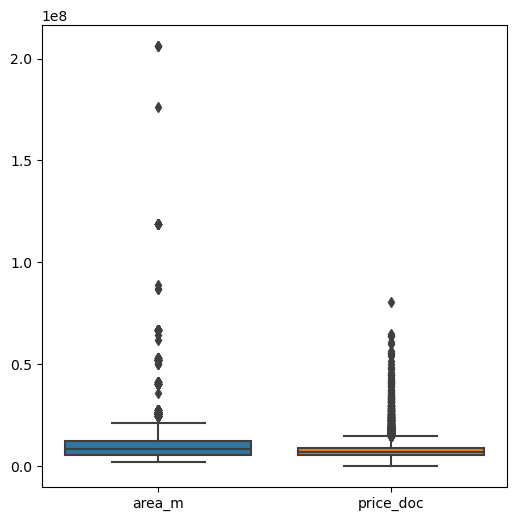

In [22]:
plt.figure(figsize=(6,6))
sns.boxplot(data=df[['area_m', 'price_doc']])

<Axes: >

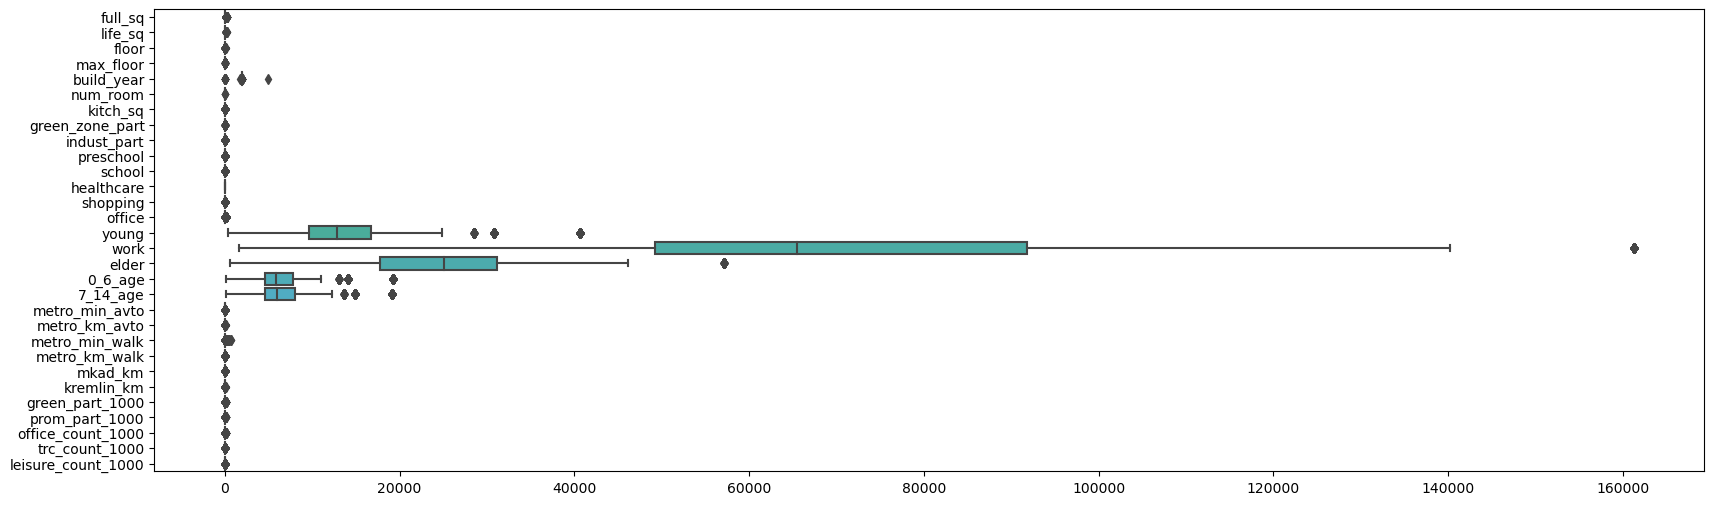

In [23]:
plt.figure(figsize=(20,6))
sns.boxplot(data=df.drop(['area_m', 'price_doc'], axis=1), orient='h')

Чистим данные методом IQR и удалим из датасета наблюдения выше 99 и ниже 1 персентилей.

In [24]:
numeric_df = df.select_dtypes(include=['number']).copy()

upper_percentile = 99
lower_percentile = 1

for col in numeric_df.columns:
    upper_limit = np.percentile(numeric_df[col], upper_percentile)
    lower_limit = np.percentile(numeric_df[col], lower_percentile)
    numeric_df = numeric_df[(numeric_df[col] <= upper_limit) & (numeric_df[col] >= lower_limit)]

non_numeric_df = df.select_dtypes(exclude=['number'])

if not non_numeric_df.empty:
    cleaned_df = pd.concat([numeric_df, non_numeric_df.loc[numeric_df.index]], axis=1)
else:
    cleaned_df = numeric_df

print(f"Размер исходного DataFrame: {df.shape}")
print(f"Размер DataFrame после очистки выбросов: {cleaned_df.shape}")

Размер исходного DataFrame: (8806, 36)
Размер DataFrame после очистки выбросов: (6158, 36)


In [25]:
df = cleaned_df
df.shape

(6158, 36)

#### Кодирование категориальных признаков

In [26]:
#определим категориальные признаки 
categorical_features = []

for col in cleaned_df.columns:
    unique_count = cleaned_df[col].nunique()
    dtype = cleaned_df[col].dtype  
    if dtype == 'object': 
        categorical_features.append(col)

print(categorical_features)

['material', 'sub_area', 'radiation', 'detention']


In [27]:
df_1 = df.copy()

In [28]:
#для начала просто переведем наши переменные из текста в числа, а уже потом подумаем насчет введения фиктивных переменных 
label_encoder = LabelEncoder()

for column in categorical_features:
    cleaned_df[column] = label_encoder.fit_transform(cleaned_df[column])

#### Построение модели линейной регрессии на всем наборе данных, подгонка - МНК

In [29]:
df.columns

Index(['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room',
       'kitch_sq', 'area_m', 'green_zone_part', 'indust_part', 'preschool',
       'school', 'healthcare', 'shopping', 'office', 'young', 'work', 'elder',
       '0_6_age', '7_14_age', 'metro_min_avto', 'metro_km_avto',
       'metro_min_walk', 'metro_km_walk', 'mkad_km', 'kremlin_km',
       'green_part_1000', 'prom_part_1000', 'office_count_1000',
       'trc_count_1000', 'leisure_count_1000', 'price_doc', 'material',
       'sub_area', 'radiation', 'detention'],
      dtype='object')

In [30]:
X = df.drop(["price_doc"], axis=1)
y = df[["price_doc"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
reg = LinearRegression().fit(train_X, train_y)

In [32]:
reg.score(train_X, train_y)

0.43565903603895983

In [33]:
reg.score(test_X, test_y)

0.4201235460595789

In [39]:
mean_squared_error(reg.predict(train_X), train_y)

5957085416670.209

In [40]:
mean_squared_error(reg.predict(test_X), test_y)

5836427492185.755

Пока грустно, так что отбираем признаки. 

## Корреляционный анализ

In [45]:
correlation_matrix = df.corr()  

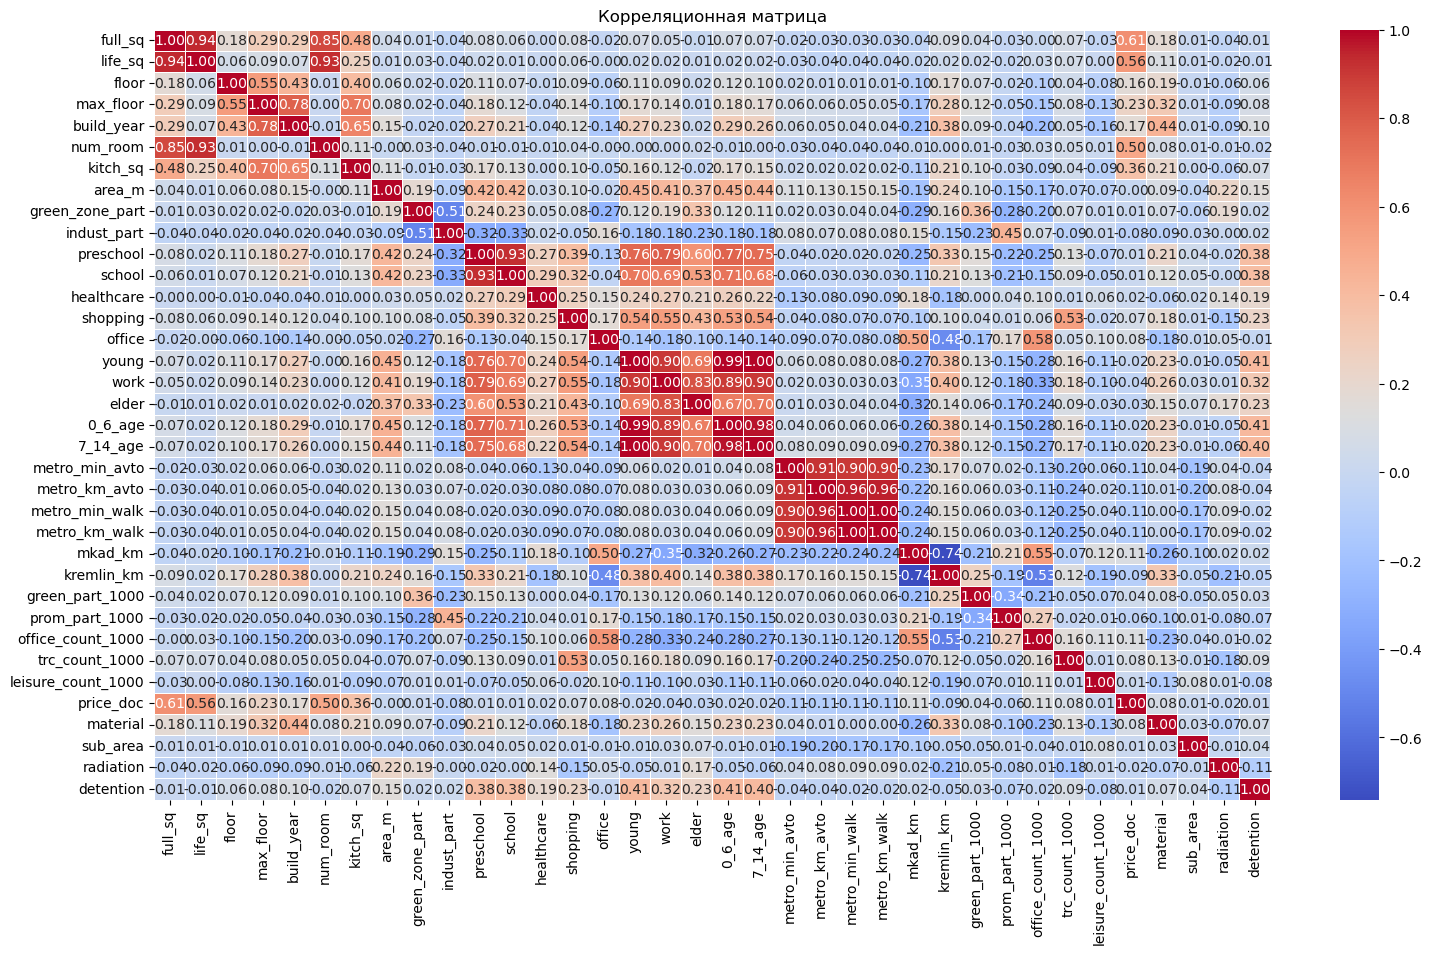

In [46]:
plt.figure(figsize=(18, 10))  
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)  
plt.title("Корреляционная матрица")
plt.show()  

In [47]:
correlation_matrix = df.corr()
target_correlations = correlation_matrix['price_doc'].abs().sort_values(ascending=False)
target_correlations.head()

price_doc    1.000000
full_sq      0.612358
life_sq      0.562448
num_room     0.497428
kitch_sq     0.355341
Name: price_doc, dtype: float64

Смотрим, как эти признаки коррелируют между собой: 

In [48]:
full_sq_correlations = correlation_matrix['full_sq'].abs().sort_values(ascending=False)
full_sq_correlations.head()

full_sq      1.000000
life_sq      0.944581
num_room     0.851778
price_doc    0.612358
kitch_sq     0.484646
Name: full_sq, dtype: float64

Коррелирует с life_sq сильнее, чем с результатом 

In [49]:
life_sq_correlations = correlation_matrix['life_sq'].abs().sort_values(ascending=False)
life_sq_correlations.head()

life_sq      1.000000
full_sq      0.944581
num_room     0.931434
price_doc    0.562448
kitch_sq     0.249919
Name: life_sq, dtype: float64

In [50]:
num_room_correlations = correlation_matrix['num_room'].abs().sort_values(ascending=False)
num_room_correlations.head()

num_room     1.000000
life_sq      0.931434
full_sq      0.851778
price_doc    0.497428
kitch_sq     0.105826
Name: num_room, dtype: float64

In [51]:
kitch_sq_correlations = correlation_matrix['kitch_sq'].abs().sort_values(ascending=False)
kitch_sq_correlations.head()

kitch_sq      1.000000
max_floor     0.696533
build_year    0.650992
full_sq       0.484646
floor         0.396542
Name: kitch_sq, dtype: float64

(((((

### Шепли

In [55]:
X = df.drop(["price_doc"], axis=1)
y = df[["price_doc"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
reg = LinearRegression().fit(train_X, train_y)

In [57]:
explainer = shap.LinearExplainer(reg, train_X) 

shap_values = explainer.shap_values(test_X)

shap_sum = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame(list(zip(X.columns, shap_sum)), columns=['feature', 'SHAP_importance'])
feature_importance.sort_values('SHAP_importance', ascending=False, inplace=True)

feature_importance.head()

,feature,SHAP_importance
15,young,3.012753e+06
18,0_6_age,1.875180e+06
0,full_sq,1.575334e+06
19,7_14_age,1.094781e+06
25,kremlin_km,3.229685e+05


### Пермутационная важность

In [58]:
reg_score = reg.score(test_X, test_y)

r_multi = permutation_importance(reg, test_X, test_y, n_repeats=30, random_state=1) 

feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': r_multi.importances_mean})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

feature_importance_df.head()

,feature,importance
15,young,3.051025
18,0_6_age,1.247661
0,full_sq,0.736166
19,7_14_age,0.414396
25,kremlin_km,0.027027


Попробуем построить модель, содержащую признаки: 
    
- full_sq
- 7_14_age
- 0_6_age
- work
- kremlin_km
- young


#### Линейная регрессия на отобранных признаках, МНК

In [65]:
df_new = df[['price_doc', 'full_sq', '7_14_age', '0_6_age', 
                             'work', 'kremlin_km', 'young']]

In [66]:
X = df_new.drop(["price_doc"], axis=1)
y = df_new[["price_doc"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [67]:
reg = LinearRegression().fit(train_X, train_y)

In [68]:
reg.score(train_X, train_y)

0.40615021284421593

In [69]:
reg.score(test_X, test_y)

0.3840229672870237

In [70]:
mean_squared_error(reg.predict(train_X), train_y)

6268575440507.366

In [71]:
mean_squared_error(reg.predict(test_X), test_y)

6199778011076.8125

very sad

#### Добавим фиктивные переменные

Используем метод pd.get_dummies.

In [72]:
df_1 = df_1[['price_doc', 'full_sq', '7_14_age', '0_6_age', 
                             'work', 'kremlin_km', 'young', 'material', 'sub_area', 'radiation', 'detention']]

In [73]:
encoded_df = pd.get_dummies(df_1, columns=['material', 'sub_area', 'radiation', 'detention'], drop_first=True)

In [74]:
X = encoded_df.drop(["price_doc"], axis=1)
y = encoded_df[["price_doc"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

In [75]:
reg = LinearRegression().fit(train_X, train_y)

In [76]:
reg.score(train_X, train_y)

0.45132337344706785

In [77]:
reg.score(test_X, test_y)

0.4480667825167651

Чуть-чуть лучше

#### Регуляризация + стандартизация

Добавим в нашу модель регуляризацию по Риджу и по Лассо, а также посмотрим, что будет дальше.

In [78]:
lasso = Lasso(alpha=1.0).fit(train_X, train_y)
ridge = Ridge(alpha=1.0).fit(train_X, train_y)

/Users/snezana/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e+16, tolerance: 5.156e+12
  model = cd_fast.enet_coordinate_descent(


In [79]:
ridge_pred = ridge.predict(train_X)
r2_score(train_y, ridge_pred)

0.4511310996336443

In [80]:
ridge_pred = ridge.predict(test_X)
r2_score(test_y, ridge_pred)

0.4485538542540469

In [81]:
lasso_pred = lasso.predict(train_X)
r2_score(train_y, lasso_pred)

0.45132335101930254

In [82]:
lasso_pred = lasso.predict(test_X)
r2_score(test_y, lasso_pred)

0.448065699523601

Метрики качества модели линейной регрессии, построенной на отобранных признаках, с введением фиктивных переменных и использованием регуляризации по Риджу и по Лассо, дали примерно одинаковые результаты. 

#### Линейная регрессия на всем наборе данных + фиктивные переменные + регуляризация 

Еще так попробуем

In [83]:
new_encoded_df = pd.get_dummies(cleaned_df, columns=['material', 'sub_area', 'radiation', 'detention'], drop_first=True)

In [84]:
X = new_encoded_df.drop(["price_doc"], axis=1)
y = new_encoded_df[["price_doc"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [85]:
lasso = Lasso(alpha=1.0).fit(train_X, train_y)
ridge = Ridge(alpha=1.0).fit(train_X, train_y)

/Users/snezana/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.130e+16, tolerance: 4.354e+12
  model = cd_fast.enet_coordinate_descent(
/Users/snezana/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.29474e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [86]:
ridge_pred = ridge.predict(train_X)
r2_score(train_y, ridge_pred)

0.48084352853014545

In [87]:
ridge_pred = ridge.predict(test_X)
r2_score(test_y, ridge_pred)

0.4263110050764569

In [88]:
lasso_pred = lasso.predict(train_X)
r2_score(train_y, lasso_pred)

0.4809809698127384

In [89]:
lasso_pred = lasso.predict(test_X)
r2_score(test_y, lasso_pred)

0.4245321339695217

#### Добавим стандартизацию 

In [90]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)

test_X = scaler.transform(test_X)

train_X = pd.DataFrame(train_X, columns=X.columns)
test_X = pd.DataFrame(test_X, columns=X.columns)

In [91]:
reg = LinearRegression().fit(train_X, train_y)

In [92]:
reg.score(train_X, train_y)

0.48099484970845907

In [179]:
reg.score(test_X, test_y)

0.42418943125455644

Результаты со стандартизацией набора данных сравнимы с результатами без стандартизации. 

R^2 получился плохой, но больше я не успеваю (MSE тоже)

Что можно рассмотреть подробнее:

- Категориальные переменные модели. Отобрать из них те, в которых наиболее заметны различия таргета (цены) по группам этих категориальных переменных. 
- Отобрать лучше признаки, мои скорее всего не очень. 
- OneHotEncoder - обычно категоризация переменных с помощью этого метода дает более высокое качество, надо его еще попробовать
- Полиномиальные признаки попробовать построить, но для этого нужно лучше понимать вклад каждой переменной в результат. 